## Counting number of solutions in Grover operator

In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
import numpy as np

In [2]:
def Uo(n=3):
    uo = QuantumCircuit(n)
    uo.h(n-1)
    uo.mcx([0,1],2,ctrl_state='01')
    uo.mcx([0,1],2,ctrl_state='10')
    uo.h(n-1)
    return uo

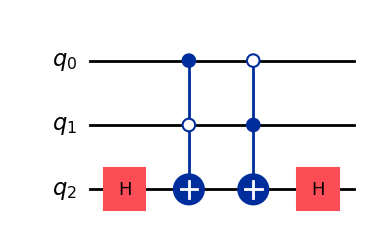

In [3]:

Uo().draw('mpl')

### Please note that I add global phase in below circuit to make it exactly the operator V that we used analytically

In [4]:
def v_op(n=3, global_phase = np.pi):
    gr = QuantumCircuit(n, global_phase =global_phase)
    gr.h(range(n))
    gr.x(n-1)
    gr.h(n-1)
    gr.mcx([0,1],2,ctrl_state='00')
    gr.h(n-1)
    gr.x(n-1)
    gr.h(range(n))
    return gr

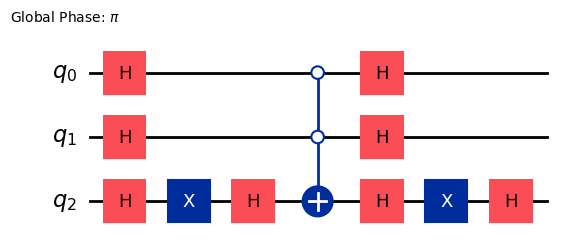

In [5]:

v_op().draw('mpl')


In [9]:
Uo_gate = Uo().to_gate()
Uo_gate.label = "Uf"
Con_Uo =Uo_gate.control()
V_gate = v_op().to_gate()
V_gate.label = "V"
Con_V =V_gate.control()

In [10]:
from numpy import pi
def IQFT(n,name='IQFT'):
    iqftn=QuantumCircuit(n,name=name)
    for i in range(int(n/2)):
        iqftn.swap(i,n-1-i)
    for i in range(0,n):
        p=0
        iqftn.barrier()
        for j in range(i):
            p+=1
            iqftn.cp(-pi/(2**(p)),i-j-1,i)
        iqftn.h(i)
    return iqftn

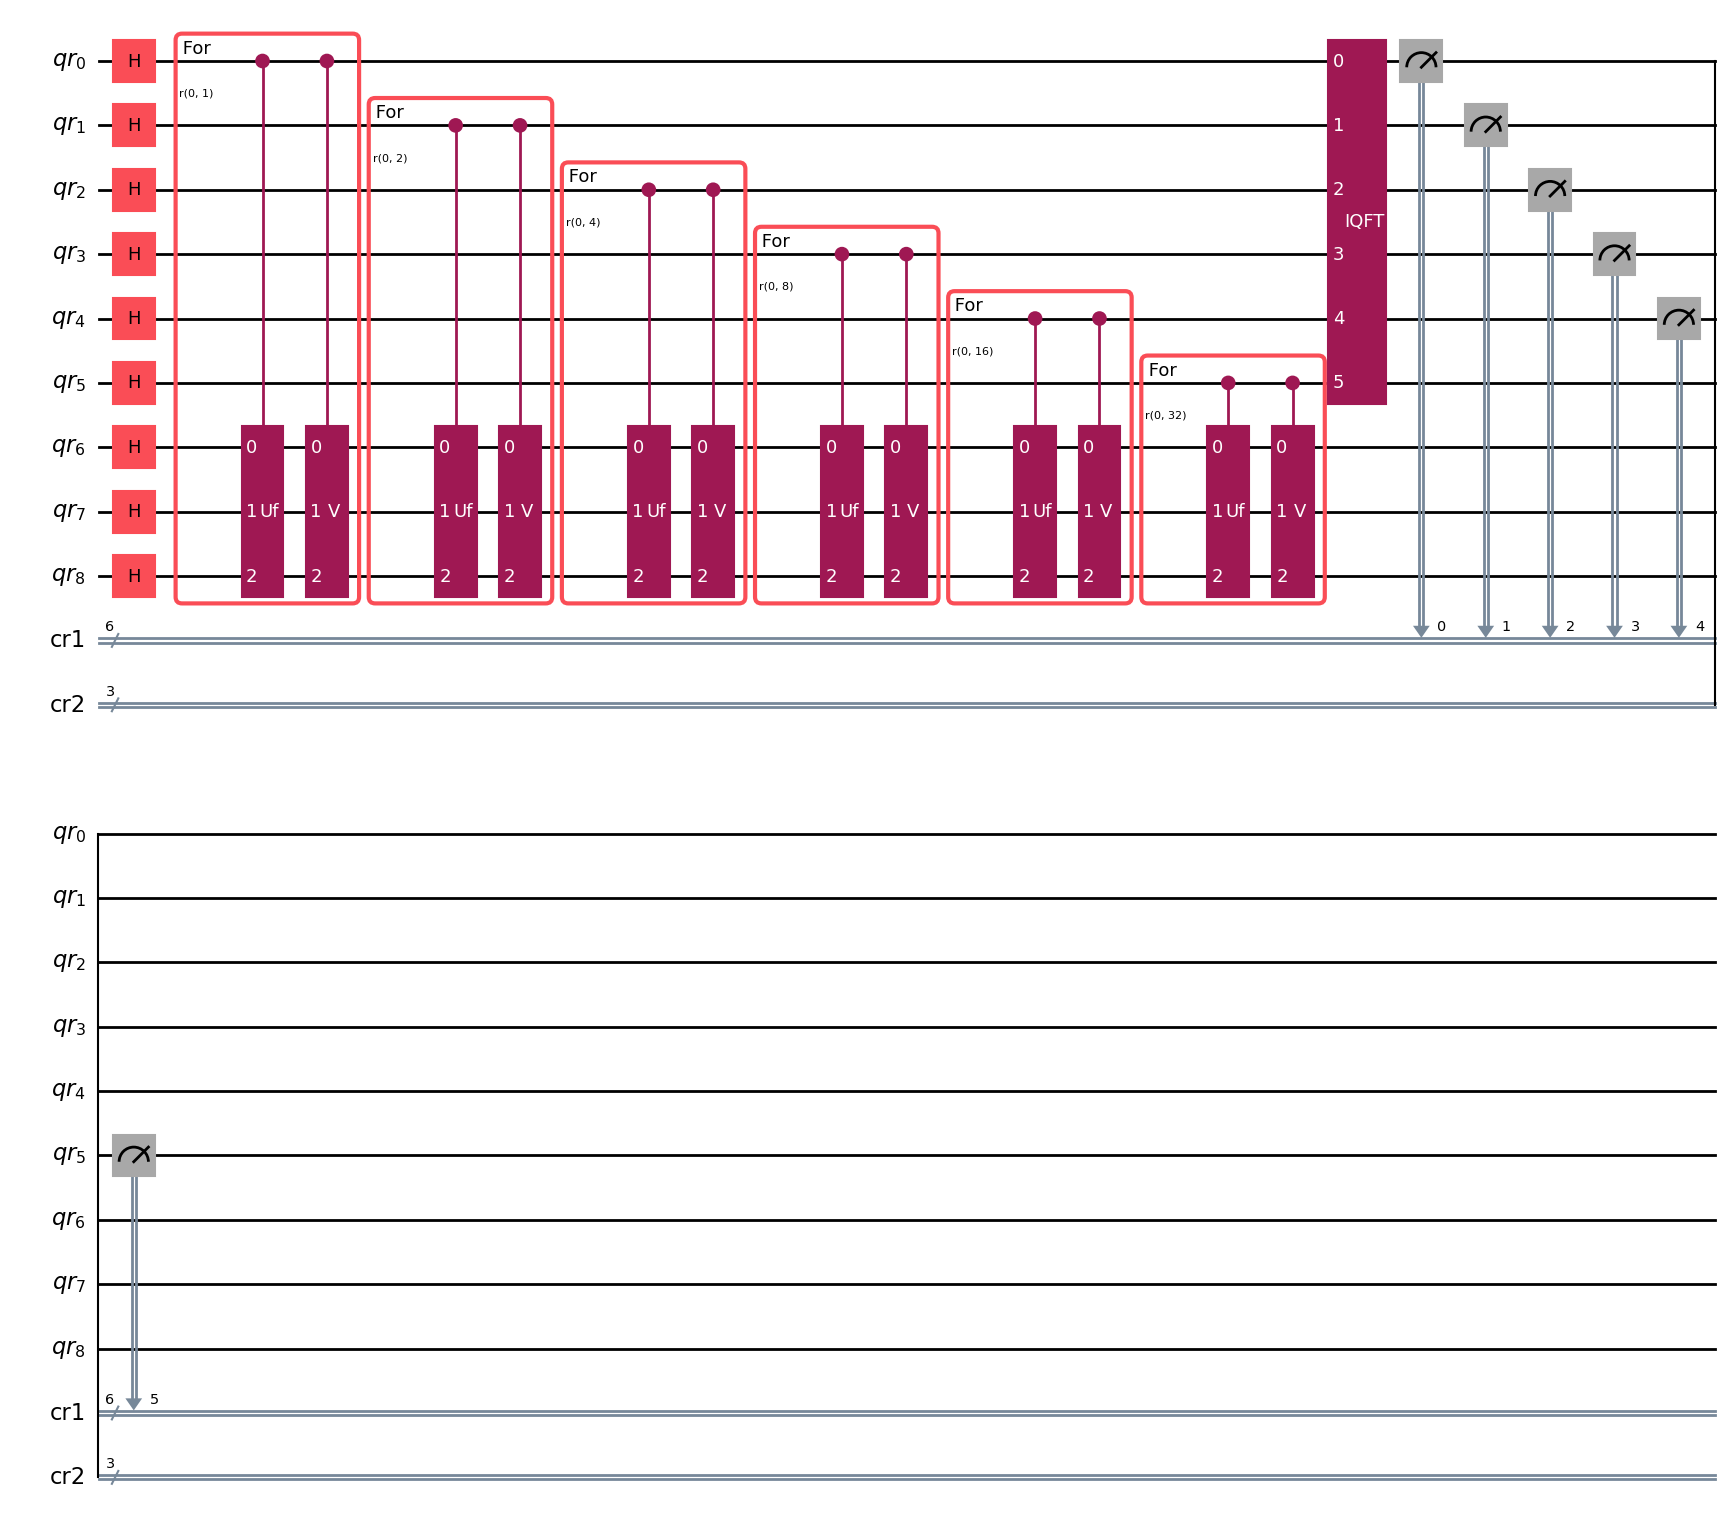

In [28]:
n=3
c=6
qr = QuantumRegister(n+c, name='qr')
cr1 = ClassicalRegister(c, name='cr1')
cr2 = ClassicalRegister(n, name='cr2')
qc=QuantumCircuit(qr,cr1,cr2)

for qubit in range(c):
    qc.h(qubit)

qc.h(range(c,c+n))
for x in range(c):
        exponent = 2**(x)
        with qc.for_loop(range(exponent)) as j:
            qc.append(Con_Uo,[x] + list(range(c, n+c)))
            qc.append(Con_V,[x] + list(range(c, n+c)))

qc.append(IQFT(c), range(c))       

for i in range(c):
    qc.measure(qr[i],cr1[i])

    
qc.draw('mpl')

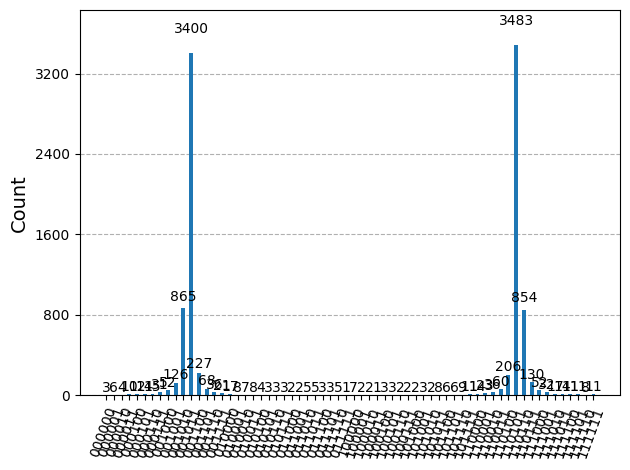

In [29]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit import transpile
backend_aer = AerSimulator()


qc_aer = transpile(qc, backend_aer)
sampler = Sampler(mode=backend_aer)
job = sampler.run([qc_aer],shots=10000)
result = job.result()
counts_phase = result[0].data.cr1.get_counts()



plot_histogram(counts_phase)

In [30]:
phase = max(counts_phase, key=counts_phase.get)
print(phase)

110101


In [31]:
measured_theta = int(phase, 2)/2**c
import numpy as np

print("Using ", c,"measured theta = ",measured_theta, " qubits from first highest peak mu = ", 2**n*np.sin(measured_theta*2*np.pi/2)**2)

Using  6 measured theta =  0.828125  qubits from first highest peak mu =  2.1144130526960097


In [32]:
counts_phase.pop(phase)
phase2 = max(counts_phase, key=counts_phase.get)
print(phase2)

001011


In [33]:
measured_theta = int(phase2, 2)/2**c
import numpy as np
print("Using ", c, " qubits from second highest peak mu = ", 2**n*np.sin(measured_theta*2*np.pi/2)**2)

Using  6  qubits from second highest peak mu =  2.1144130526960088
